In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('dark')

Read in XMM data and bin to 100 seconds

In [75]:
X = np.genfromtxt('../data/ts_file_xmm_all_MJD.dat',skip_header=1).T
t, y, s = X
l = np.isfinite(y) * np.isfinite(t)
t = t[l]
y = y[l]
s = s[l]

In [76]:
dt = 100.0 / (24*3600.0)
tb = np.r_[t.min()+dt/2.:t.max()+dt/2.:dt]
yb = np.zeros_like(tb)
sb = np.zeros_like(tb)
indices = np.digitize(t,tb)
for i in range(len(tb)):
    c = (indices == i)
    yb[i] = y[c].sum()
    sb[i] = np.sqrt(np.sum(s[c]**2))
l = yb > 0
tb = tb[l] 
yb = yb[l]
sb = sb[l]

Find boundaries of each run

In [77]:
gap = 1.0
x_ranges = []
ob = np.zeros_like(tb, int)
tp = tb[0] - dt
xr0 = tb[0]
ii = 0
for i,t_ in enumerate(tb):
    if t_ > (tp + gap):
        x_ranges.append((xr0-0.1-t0,tp+0.1-t0))
        xr0 = t_
        ii += 1
    tp = np.copy(t_)
    ob[i] = ii
x_ranges.append((xr0-0.1-t0,tp+0.1-t0))
print(x_ranges)
print(np.unique(ob))

[(476.17579050925997, 476.89546643578797), (499.12254979523277, 500.8676886859175), (634.8123647680113, 636.538985140156)]
[0 1 2]


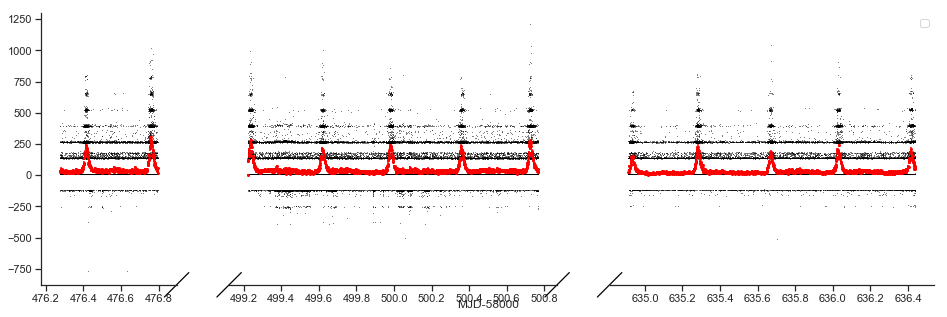

In [78]:
plt.figure(figsize=(16,5))
bax = brokenaxes(xlims=x_ranges)
bax.plot(t-t0,y*100,'k,',alpha=0.5)
bax.errorbar(tb-t0,yb,yerr=sb,fmt='r.',ms=4)
bax.set_xlabel('MJD-{:d}'.format(t0))
bax.legend(loc=0)

Read in Chandra data, bin to 1000s (to avoid quantization, but keep enough time resolution to sample the pulses)

In [84]:
C = np.genfromtxt('../data/ts_file_CHANDRA.dat').T
tc, yc, sc = C
l = np.isfinite(yc) * np.isfinite(tc)
tc = tc[l]
yc = yc[l]
sc = sc[l]

In [85]:
dtc = 1000.0 / (24*3600.0)
tcb = np.r_[tc.min()+dtc/2.:tc.max()+dtc/2.:dtc]
ycb = np.zeros_like(tcb)
scb = np.zeros_like(tcb)
indices = np.digitize(tc,tcb)
for i in range(len(tcb)):
    c = (indices == i)
    ycb[i] = yc[c].sum()
    scb[i] = np.sqrt(np.sum(sc[c]**2))
l = ycb > 0
tcb = tcb[l] 
ycb = ycb[l]
scb = scb[l]

Text(0.5, 0, 'MJD-58000')

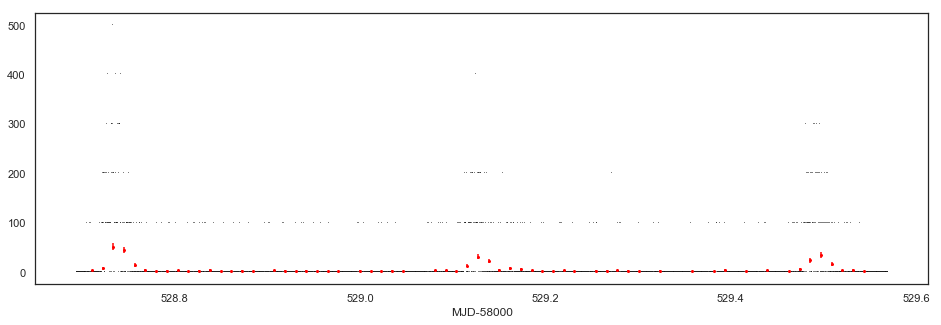

In [86]:
plt.figure(figsize=(16,5))
plt.plot(tc-t0,yc*100,'k,',alpha=0.5)
plt.errorbar(tcb-t0,ycb,yerr=scb,fmt='r.',ms=4)
plt.xlabel('MJD-{:d}'.format(t0))

Combine XMM and Chandra (rescaling the Chandra data to make phase-folding easier)

In [90]:
fac = np.mean(yb) / np.mean(ycb)
t = np.concatenate([tb,tcb])
y = np.concatenate([yb,ycb*fac])
s = np.concatenate([sb,scb*fac])
obmax = max(ob)
o = np.concatenate([ob,np.ones_like(scb,int)+obmax])

In [88]:
x_ranges.append((min(tcb)-0.1-t0,max(tcb)+0.1-t0))
x_ranges.sort()
print(x_ranges)

[(476.17579050925997, 476.89546643578797), (499.12254979523277, 500.8676886859175), (528.6104375609939, 529.6437708942467), (634.8123647680113, 636.538985140156)]


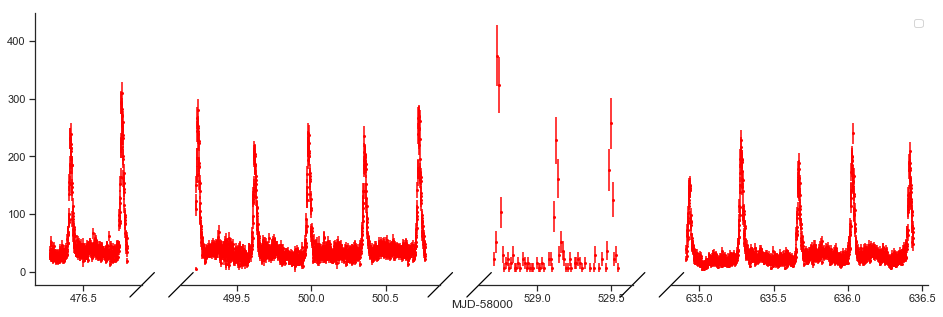

In [91]:
plt.figure(figsize=(16,5))
bax = brokenaxes(xlims=x_ranges)
bax.errorbar(t-t0,y,yerr=s,fmt='r.',ms=4)
bax.set_xlabel('MJD-{:d}'.format(t0))
bax.legend(loc=0)

Now try to find best period using Lomb Scargle

In [111]:
from astropy.stats import LombScargle
def explore_period(t,y,e,o,ymin=50,pmin=0.3,pmax=0.6,nper=50000):
    periods = np.linspace(pmin,pmax,nper)
    l = y > ymin
    power = LombScargle(t[l], y[l], dy = e[l]).power(1./periods)
    per_init = periods[np.argmax(power)]
    fig, axes = plt.subplots(2,2,figsize=(16,10))
    axes[0,0].plot(periods,power,'k-')
    axes[0,0].axvline(per_init)
    axes[0,0].set_title('Lomb-Scargle periodogram')
    axes[0,0].set_xlabel('period (sec)')
    axes[0,0].set_ylabel('power')
    print('Best-fit period: {:.5f} days'.format(per_init))
    # Now fold LC on initial period estimate and locate peak
    ou = np.unique(o)
    if len(ou) > 1:
        for oo in ou:
            l = o == oo
            axes[0,1].errorbar(t[l],y[l],yerr=s[l],fmt='.',ms=4,alpha=0.5)
    else:
        axes[0,1].scatter(t,y,c=t,s=4,alpha=0.5)
    axes[0,1].set_title('LC')
    axes[0,1].set_xlabel('time (seconds)')
    axes[0,1].set_ylabel('counts')
    phase = (t % per_init) / per_init
    phase[phase>0.8] -= 1
    if len(ou) > 1:
        for oo in ou:
            l = o == oo
            axes[1,0].errorbar(phase[l],y[l],yerr=s[l],fmt='.',ms=4,alpha=0.5)
    else:
        axes[1,0].scatter(phase,y,c=t,s=4,alpha=0.5)
    axes[1,0].set_title('LC folded on P')
    axes[1,0].set_xlabel('phase')
    axes[1,0].set_ylabel('counts')
    per_init *= 2
    phase = (t % per_init) / per_init
    phase[phase>0.8] -= 1
    if len(ou) > 1:
        for oo in ou:
            l = o == oo
            axes[1,1].errorbar(phase[l],y[l],yerr=s[l],fmt='.',ms=4,alpha=0.5)
    else:
        axes[1,1].scatter(phase,y,c=t,s=4,alpha=0.5)
    axes[1,1].set_title('LC folded on 2P')
    axes[1,1].set_xlabel('phase')
    axes[1,1].set_ylabel('counts')

Best-fit period: 0.36863 days


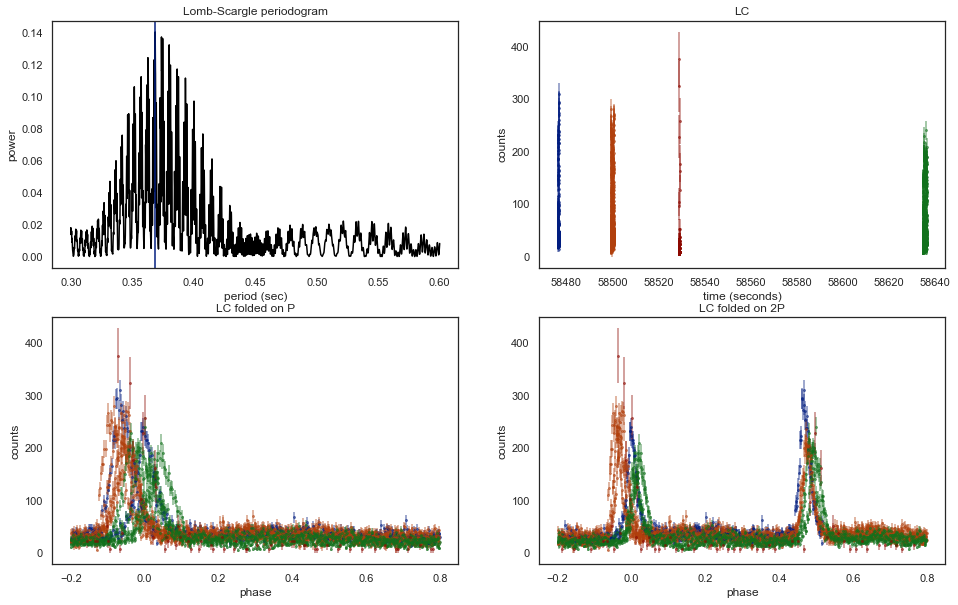

In [109]:
explore_period(t,y,s,o)

Ok, it doesn't look like a single period fits all 4 runs. Try phase-folding them separately

Best-fit period: 0.36884 days
Best-fit period: 0.36746 days
Best-fit period: 0.37441 days
Best-fit period: 0.38113 days


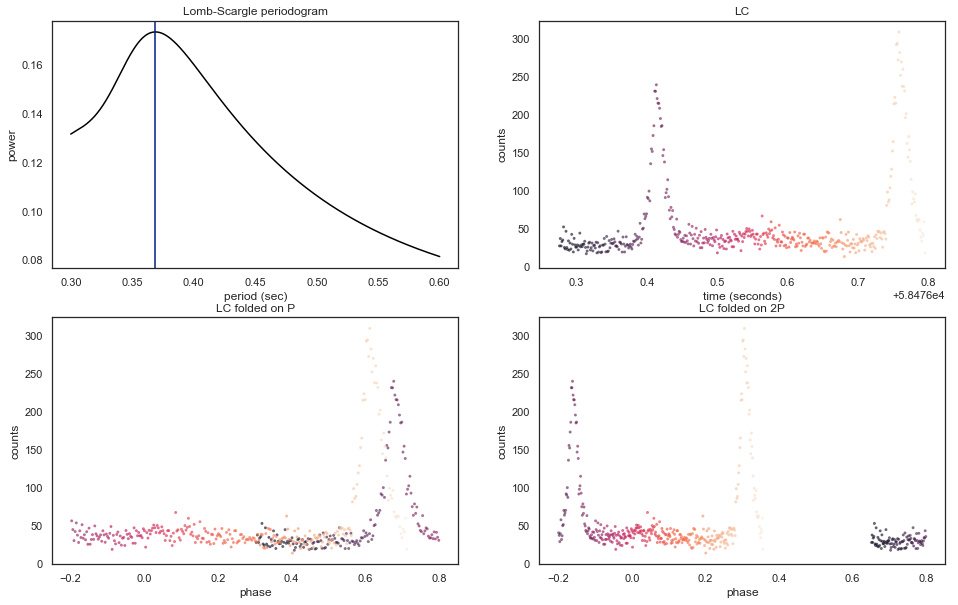

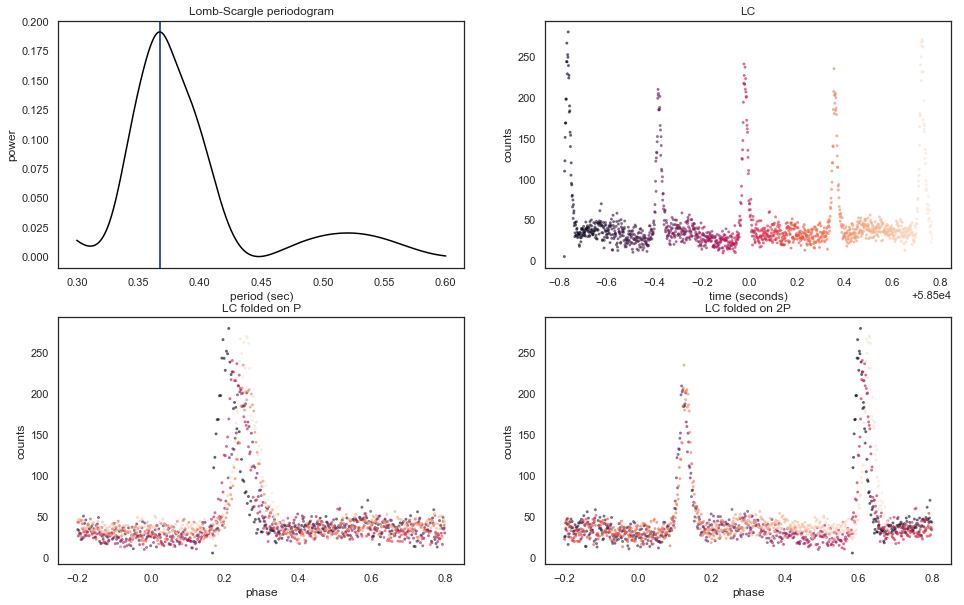

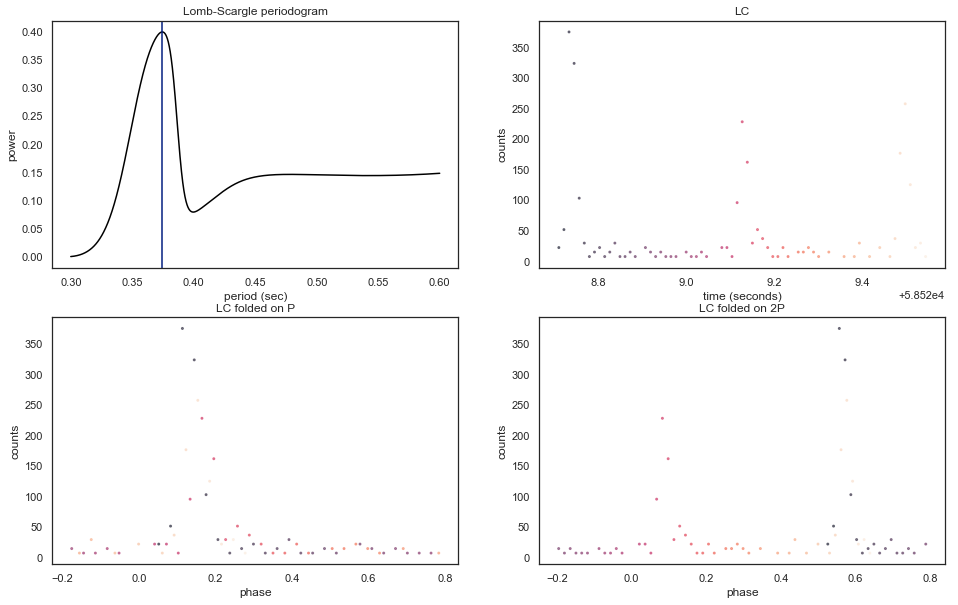

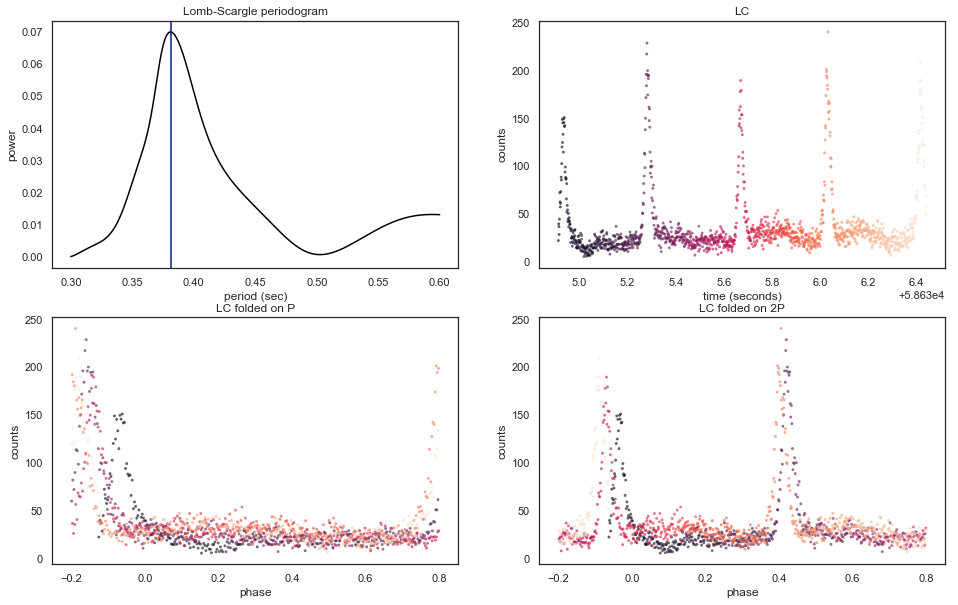

In [112]:
ou = np.array([0,1,3,2]) # this ensures the runs are done in chronological order
for oo in ou:
    l = o == oo
    explore_period(t[l],y[l],s[l],o[l])

Even within each run, there appears to be enough evolution (particularly of the phase of the smaller pulse) that a single period fit doesn't work terribly well. Thus we will need to move to fitting for the times of individual pulses. For now, let's save the combined dataset as it is.

In [118]:
i = np.argsort(t)
ts = t[i]
ys = y[i]
ss = s[i]
os = o[i]
l1 = os == 2
l2 = os == 3
os[l1] = 3
os[l2] = 2
ys[l2] /= fac
ss[l2] /= fac

In [119]:
X = np.zeros((4,len(ts)))
X[0] = ts - t0
X[1] = ys
X[2] = ss
X[3] = os
np.savetxt('../data/combined_binned.dat',X.T,\
           fmt='%10.5f %6.2f %6.2f %1d',\
           header=' MJD-{:5d} {:6s} {:6s} {:3s}'.format(t0,'counts','error','run'))